# fscLVM tutorial 

In this notebook we illustrate how f-scLVM can be used to identify biological drivers on the mESC cell cycle staged dataset.

First, we load some modules and set some directories

In [1]:
import os
import fscLVM
import pdb
from fscLVM import plotFactors, plotRelevance, plotLoadings, saveFA, dumpFA
%pylab inline

#specify where the hdf5 file is
data_dir = '../data/'
out_dir = './results'



Populating the interactive namespace from numpy and matplotlib


f-scLVM expects an expression file, typically with log transformed gene expression values  as well as a gene set annotation. These data can be provided as single hdf5 file, which can be generated using separate R scripts (in the R folder). Alternatively, the expression matrix and the annotation can be loaded as text files in python. 






# Loading raw expression data and gene set annotations

By default we here load the MsigDB annotation, which needs to be downloaded separately from the Broad web page. 

In [2]:
####
#Option 1: load a pre-defined hdf5 file
#We provide an (optional) hdf file with the required data - this was generated using
#the R script write_fscLVM.R in the R folder
if 0:
    annoDB = 'MSigDB'
    dFile = os.path.join(data_dir,'Buettneretal2015.hdf5')
    data = fscLVM.load_hdf5(dFile, anno=annoDB)
    
####

####
#Option 2: load the annotation and the data directly
if 1:
    #Annotation file
    #annoFile = os.path.join(data_dir,'h.all.v5.0.symbols.gmt.txt') #MSigDB
    #annoDB   = 'MSigDB'
    #if not os.path.exists(annoFile):
    #    raise Exception("MSigDB annotation file needs to be downloaded manually")
    #Note: the license of MSigDB does not permit redistribution of the raw annotation files.
    #Please register at http://software.broadinstitute.org/gsea/msigdb and download the
    #hallmark gene sets and place the file in data folder.

    annoFile = os.path.join(data_dir,'c2.cp.reactome.v4.0.symbols.gmt.txt') #REACTOME
    annoDB   = 'REACTOME'

    #dataFile: csv file with log expresison values
    dataFile = os.path.join(data_dir,'Buettneretal.csv.gz')
    data = fscLVM.utils.load_txt(dataFile=dataFile,annoFiles=annoFile,annoDBs=annoDB)
####

###alternatively the data can be loaded from the provided hdf5 file
#dFile = 'Buettneretal2015.hdf5'
#data = fscLVM.load_hdf5(dFile, data_dir=data_dir)


#print statistics for the loaded dataset
print ("Loaded {:d} cells, {:d} genes".format(data['Y'].shape[0],data['Y'].shape[1]))
print ("Annotation: {:d} terms".format(len(data['terms'])))

Data file loaded
0 terms out of 674 terms loaded for current annotation file
10 terms out of 674 terms loaded for current annotation file
20 terms out of 674 terms loaded for current annotation file
30 terms out of 674 terms loaded for current annotation file
40 terms out of 674 terms loaded for current annotation file
50 terms out of 674 terms loaded for current annotation file
60 terms out of 674 terms loaded for current annotation file
70 terms out of 674 terms loaded for current annotation file
80 terms out of 674 terms loaded for current annotation file
90 terms out of 674 terms loaded for current annotation file
100 terms out of 674 terms loaded for current annotation file
110 terms out of 674 terms loaded for current annotation file
120 terms out of 674 terms loaded for current annotation file
130 terms out of 674 terms loaded for current annotation file
140 terms out of 674 terms loaded for current annotation file
150 terms out of 674 terms loaded for current annotation file
16

# Initializiting the f-scLVM model

In [3]:
#I: indicator matrix that assigns genes to pathways
I = data['I'] #if loaded from the hdf file change to I = data['IMSigDB']
#Y: log expresison values 
Y = data['Y']
#terms: ther names of the terms
terms = data['terms']

#gene_ids: the ids of the genes in Y
gene_ids = data['genes']

#initialize FA instance, here using a Gaussian noise model and fitting 3 dense hidden factors
FA = fscLVM.initFA(Y, terms,I, gene_ids=gene_ids, noise='gauss', 
                    nHidden=3, nHiddenSparse=0)




## Model training

In [5]:
#model training
seed(123)
#FA.learnPi=True
FA.train()

#print diagnostics
FA.printDiagnostics()

iteration 0
Switched off factor Trans golgi network v
Switched off factor Traf6 mediated induct
Switched off factor Costimulation by the 
Switched off factor Loss of nlp from mito
Switched off factor Hiv infection
Switched off factor Trif mediated tlr3 si
Switched off factor Downstream signaling 
Switched off factor Unfolded protein resp
Switched off factor Golgi associated vesi
Switched off factor S phase
Switched off factor Hiv life cycle
Switched off factor Mrna processing
Switched off factor Signaling by erbb4
Switched off factor Signaling by fgfr
Switched off factor Il1 signaling
Switched off factor Integration of energy
Switched off factor Pi3k events in erbb2 
Switched off factor Nucleotide binding do
Switched off factor Downstream signaling 
Switched off factor Nfkb and map kinases 
Switched off factor Nrage signals death t
Switched off factor P75 ntr receptor medi
Switched off factor Regulation of insulin
Switched off factor Circadian clock
Switched off factor Myd88 mal cascad

Next, we plot the results, including  factor relevance, gene set augmentation and a scatter plot of the two most relevant factors, in this case Cell Cycle and Integrin cell surface interactions. As for the MSigDB annotations, cell cycle is identified as major driver of variability; in addition the process Integrin cell surface interactions is identified as second major difcer of varibility, reflecting differences in self-renewal capabilities (Hayashi, Yohei, et al. "Integrins regulate mouse embryonic stem cell self‐renewal." Stem cells 25.12 (2007): 3005-3015.)

/Users/flo/projects/Auto_Bionf/scLVM2/fscLVM/utils.py:403: RuntimeWarning: invalid value encountered in true_divide
  y_max = SP.ceil(max(n_gain)/gap)
/Users/flo/projects/Auto_Bionf/scLVM2/fscLVM/utils.py:404: RuntimeWarning: invalid value encountered in double_scalars
  y_min = SP.floor(min(n_loss)/gap)


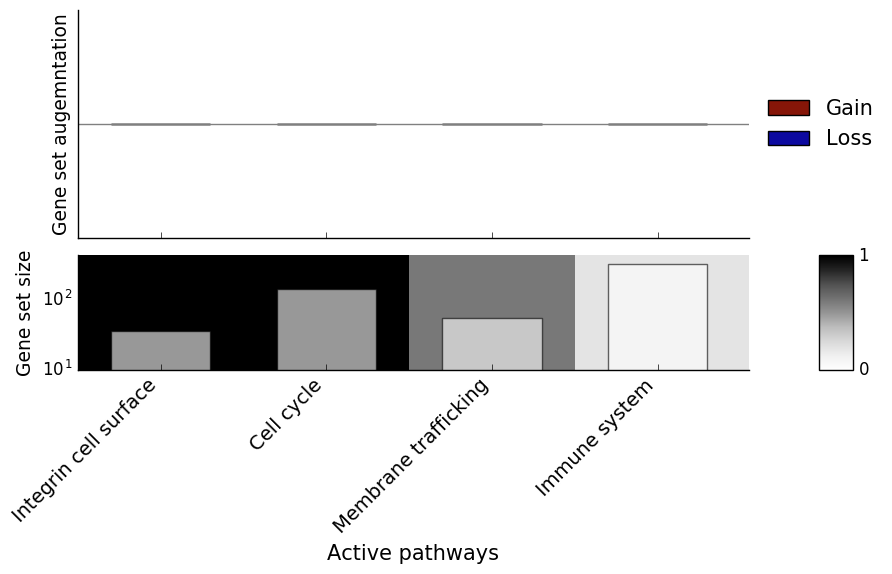

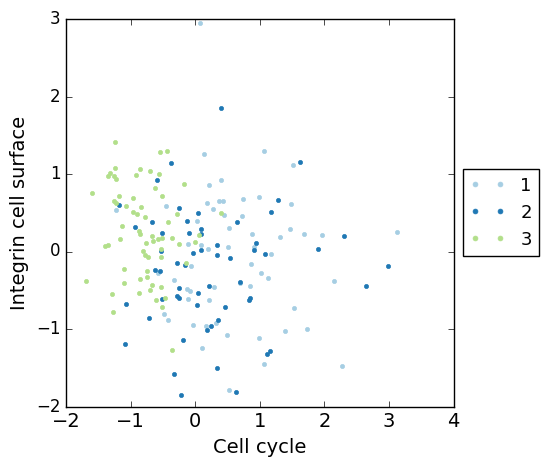

In [18]:
#plot results

fig = plotRelevance(FA)

#scatter plot of the top two factors
fig = plotFactors(FA, lab=data['lab'], terms=['Cell cycle','Integrin cell surface'], isCont=False)


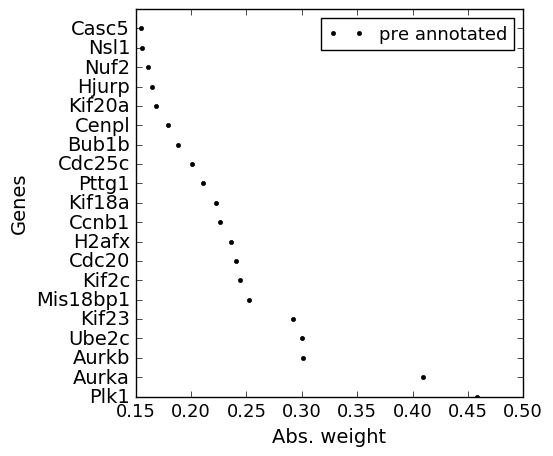

In [19]:
#visualize weights for the Cell cycle factor 

fig = plotLoadings(FA, 'Cell cycle', n_genes=20)


Finally, we can safe the model results as CSV files or using a .hdf5 file.

In [17]:
#if not os.path.exists(out_dir):
#    os.makedirs(out_dir)
#out_file_name = os.path.join(out_dir,FA.getName()+'.hdf5')
#saveFA(FA, out_name=out_file_name